In [1]:
import os
import sys
sys.path.append(os.path.abspath(r"F:\lab\EPINET_MobileViT\EPI_Stabilization\UNet_EPI_Stabilization\epinet_fun"))

from PIL import Image
import torch
from torchvision import transforms
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import vgg16
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from __future__ import print_function


from network.model_for_eval_simple import *
from network.model import *

import numpy as np
import matplotlib.pyplot as plt

import h5py
import os
import time
import datetime
import threading
import configparser
import json
from PIL import Image, ImageEnhance, ImageOps
import imageio
from scipy.ndimage import generic_filter

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from PIL import Image


c:\Users\ryuta\anaconda3\envs\Transformer\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ryuta\anaconda3\envs\Transformer\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
BATCHSIZE = 16
NUMof1epoch = 50
CROP_SIZE = 512

In [3]:

inifile = configparser.ConfigParser()
inifile.read('./config.ini', 'UTF-8')

train_dataset_list = json.loads(inifile.get('dataset_list','train_dataset_list'))
test_dataset_list = json.loads(inifile.get('dataset_list','test_dataset_list'))

dataset_path = inifile.get('PATH','dataset_path')
boolmask_img4_path = inifile.get('PATH','boolmask_img4')
boolmask_img6_path = inifile.get('PATH','boolmask_img6')
boolmask_img15_path = inifile.get('PATH','boolmask_img15')

image_width = int(inifile.get('model_1371','image_width'))
image_height = int(inifile.get('model_1371','image_height'))

batch_size_training = int(inifile.get('training_general','batch_size_training'))
batch_size_validation = int(inifile.get('training_general','batch_size_validation'))
batch_num_in_1epoch_for_training = int(inifile.get('training_general','batch_num_in_1epoch_for_training'))
training_img_size = int(inifile.get('training_general','training_img_size'))
validation_img_size = int(inifile.get('training_general','validation_img_size'))

learning_rate = float(inifile.get('training_general','learning_rate'))
validation_frequency = int(inifile.get('training_general','validation_frequency'))
save_model_frequency = int(inifile.get('training_general','save_model_frequency'))

input_ch = int(inifile.get('training_general','input_ch'))
filter_num = int(inifile.get('training_general','filter_num'))
stream_num = int(inifile.get('training_general','stream_num'))

In [4]:
train_dataset_list = [
            "additional/antinous", "additional/boardgames", "additional/dishes",   "additional/greek",
            "additional/kitchen",  "additional/medieval2",  "additional/museum",   "additional/pens",
            "additional/pillows",  "additional/platonic",   "additional/rosemary", "additional/table",
            "additional/tomb",     "additional/tower",      "additional/town",     "additional/vinyl" ]

val_dataset_list = [
            "stratified/backgammon", "stratified/dots", "stratified/pyramids", "stratified/stripes",
            "training/boxes", "training/cotton", "training/dino", "training/sideboard"]

In [5]:
def read_pfm(fpath, expected_identifier="Pf"):
    # PFM format definition: http://netpbm.sourceforge.net/doc/pfm.html
    
    def _get_next_line(f):
        next_line = f.readline().decode('utf-8').rstrip()
        # ignore comments
        while next_line.startswith('#'):
            next_line = f.readline().rstrip()
        return next_line
    
    with open(fpath, 'rb') as f:
        #  header
        identifier = _get_next_line(f)
        if identifier != expected_identifier:
            raise Exception('Unknown identifier. Expected: "%s", got: "%s".' % (expected_identifier, identifier))

        try:
            line_dimensions = _get_next_line(f)
            dimensions = line_dimensions.split(' ')
            width = int(dimensions[0].strip())
            height = int(dimensions[1].strip())
        except:
            raise Exception('Could not parse dimensions: "%s". '
                            'Expected "width height", e.g. "512 512".' % line_dimensions)

        try:
            line_scale = _get_next_line(f)
            scale = float(line_scale)
            assert scale != 0
            if scale < 0:
                endianness = "<"
            else:
                endianness = ">"
        except:
            raise Exception('Could not parse max value / endianess information: "%s". '
                            'Should be a non-zero number.' % line_scale)

        try:
            data = np.fromfile(f, "%sf" % endianness)
            data = np.reshape(data, (height, width))
            data = np.flipud(data)
            with np.errstate(invalid="ignore"):
                data *= abs(scale)
        except:
            raise Exception('Invalid binary values. Could not create %dx%d array from input.' % (height, width))

        return data

In [6]:
def B9HW_to_BH9W_EPI_gen(input_tensor, batchsize):
    if batchsize != input_tensor.size(0):
        print(f"Error : check B9HW_to_BH9W_EPI_gen")

    B = input_tensor.size(0)
    H = input_tensor.size(2)
    W = input_tensor.size(3)

    result_tensor = input_tensor.permute(0, 2, 1, 3).reshape(B, H, 9, W)

    return result_tensor

In [7]:
def save_model_and_optimizer(model, optimizer, save_path):

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    state = {
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    }

    torch.save(state, save_path)

In [8]:
class CustomDataset:
    def __init__(self, base_path, dataset_list,flag_print_distorted_path, flag_GT_output=False):
        self.base_path = base_path
        self.dataset_list = dataset_list
        self.dataset_len = len(dataset_list)
        self.n_steps = 8
        self.mu = 0
        self.sigma = 1
        self.top_idx = list(range(0, 9))
        self.bottom_idx = list(range(72, 81))
        self.flag_print_distorted_path = flag_print_distorted_path
        self.flag_GT_output = flag_GT_output

    def __getitem__(self, index):

        random_dataset_idx = random.randint(0, self.dataset_len-1)
        dataset_path = []
        dataset_path = os.path.join(self.base_path, self.dataset_list[random_dataset_idx])
        current_position = 36
        positions = [current_position]

        ########################ランダムな多視点画像を作成########################
        # ガウス分布のパラメータを設定して次の位置を計算
        for _ in range(self.n_steps):
            next_position = self.get_next_position(current_position)
            positions.append(next_position)
            current_position = next_position
        
        # ランダムな位置の画像
        images = []
        transform = transforms.ToTensor()
        for pos in positions:
            img_name = f"input_Cam{pos:03d}.png"
            img_path = os.path.join(dataset_path, img_name)
            img = Image.open(img_path).convert('RGB')
            img = img.convert('L')  # 次にモノクロに変換する
            img_tensor = transform(img)
            images.append(img_tensor)

        # テンソルを積み重ねて[i, H, W]の次元にする
        stacked_images = torch.stack(images)
        crop_size = (CROP_SIZE, CROP_SIZE)
        distorted_multiview_tensor, top, left = self.random_crop(stacked_images, crop_size)
        distorted_multiview_tensor = distorted_multiview_tensor.squeeze()
        if self.flag_print_distorted_path is True: print(f"positions: {positions}")
        
        ########################ランダムな多視点画像を作成########################

        # 正しい多視点画像
        images = []
        transform = transforms.ToTensor()
        positions = [36,37,38,39,40,41,42,43,44]
        for pos in positions:
            img_name = f"input_Cam{pos:03d}.png"
            img_path = os.path.join(dataset_path, img_name)
            img = Image.open(img_path).convert('RGB')
            img = img.convert('L')  # 次にモノクロに変換する
            img_tensor = transform(img)
            images.append(img_tensor)

        # テンソルを積み重ねて[i, H, W]の次元にする
        stacked_images = torch.stack(images)
        crop_size = (CROP_SIZE, CROP_SIZE)
        not_distorted_multiview_tensor = self.normal_crop(stacked_images, crop_size,top,left)
        not_distorted_multiview_tensor = not_distorted_multiview_tensor.squeeze()

        if self.flag_GT_output is True:
            pfm_path = os.path.join(dataset_path, "gt_disp_lowres.pfm")
            GT_tensor = torch.from_numpy(read_pfm(pfm_path).copy())
            return distorted_multiview_tensor, not_distorted_multiview_tensor, GT_tensor

        else:
            return distorted_multiview_tensor, not_distorted_multiview_tensor

    def __len__(self):
        # データセットの長さを返す。ここでは仮の値を返している。
        return BATCHSIZE * NUMof1epoch

    def get_next_position(self, pos):
        displacement = np.random.normal(self.mu, self.sigma)

        if pos in self.top_idx:
            next_pos = pos + 1
            if displacement > 1:
                next_pos = pos + 1
            elif displacement > 0.5:
                next_pos = pos + 10  # 右斜め下
            elif displacement < -1:
                next_pos = pos + 10  # 右斜め下
            else:
                next_pos = pos + 1
            
        elif pos in self.bottom_idx:
            next_pos = pos + 1
            if displacement > 1:
                next_pos = pos + 1
            elif displacement > 0.5:
                next_pos = pos - 8  # 右斜め上
            elif displacement < -1:
                next_pos = pos - 8  # 右斜め上
            else:
                next_pos = pos + 1

        else:
            next_pos = pos + 1
            if displacement > 1:
                next_pos = pos + 1
            elif displacement > 0.5:
                next_pos = pos - 8  # 右斜め上
            elif displacement < -1:
                next_pos = pos + 10  # 右斜め下
            else:
                next_pos = pos + 1

        return next_pos
    
    def random_crop(self,tensor, crop_size):
        _, _, height, width = tensor.shape
        crop_height, crop_width = crop_size

        # ランダムな開始位置を決定
        top = torch.randint(0, height - crop_height + 1, (1,)).item()
        left = torch.randint(0, width - crop_width + 1, (1,)).item()

        # 26x26のサイズを切り出し
        cropped_tensor = tensor[:, :, top:top + crop_height, left:left + crop_width]
        return cropped_tensor, top, left

    def normal_crop(self,tensor, crop_size, top, left):
        _, _, height, width = tensor.shape
        crop_height, crop_width = crop_size

        # 26x26のサイズを切り出し
        cropped_tensor = tensor[:, :, top:top + crop_height, left:left + crop_width]
        return cropped_tensor

In [9]:
class UNet_with_BN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet_with_BN, self).__init__()
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        self.bottleneck = self.conv_block(512, 1024)
        self.decoder4 = self.conv_block(1024 + 512, 512)
        self.decoder3 = self.conv_block(512 + 256, 256)
        self.decoder2 = self.conv_block(256 + 128, 128)
        self.decoder1 = self.conv_block(128 + 64, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # バッチ正規化を追加
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # バッチ正規化を追加
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        dec4 = self.decoder4(torch.cat((F.interpolate(bottleneck, scale_factor=2, mode='bilinear', align_corners=True), enc4), dim=1))
        dec3 = self.decoder3(torch.cat((F.interpolate(dec4, scale_factor=2, mode='bilinear', align_corners=True), enc3), dim=1))
        dec2 = self.decoder2(torch.cat((F.interpolate(dec3, scale_factor=2, mode='bilinear', align_corners=True), enc2), dim=1))
        dec1 = self.decoder1(torch.cat((F.interpolate(dec2, scale_factor=2, mode='bilinear', align_corners=True), enc1), dim=1))
        return self.final_conv(dec1)

In [10]:
base_path = r"F:\lab\EPINET_MobileViT\dataset\hci_dataset"
train_dataset = CustomDataset(base_path, dataset_list=train_dataset_list, flag_print_distorted_path=False)
train_dataloader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)

val_dataset = CustomDataset(base_path, dataset_list=val_dataset_list, flag_print_distorted_path=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)

UNet = UNet_with_BN(in_channels=9, out_channels=9).cuda()


#### 検証

#### 入力（揺れのある多視点画像)

In [11]:
checkpoint = torch.load(r"C:\checkpoints\epoch153_TRloss0p7199_VALloss0p7245.pth")
UNet.load_state_dict(checkpoint['model_state'])
UNet.eval()

UNet_with_BN(
  (encoder1): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

positions: [36, 37, 38, 39, 40, 41, 51, 52, 53]
Input images saved to ./input_multiview
GT images saved to ./GT_multiview


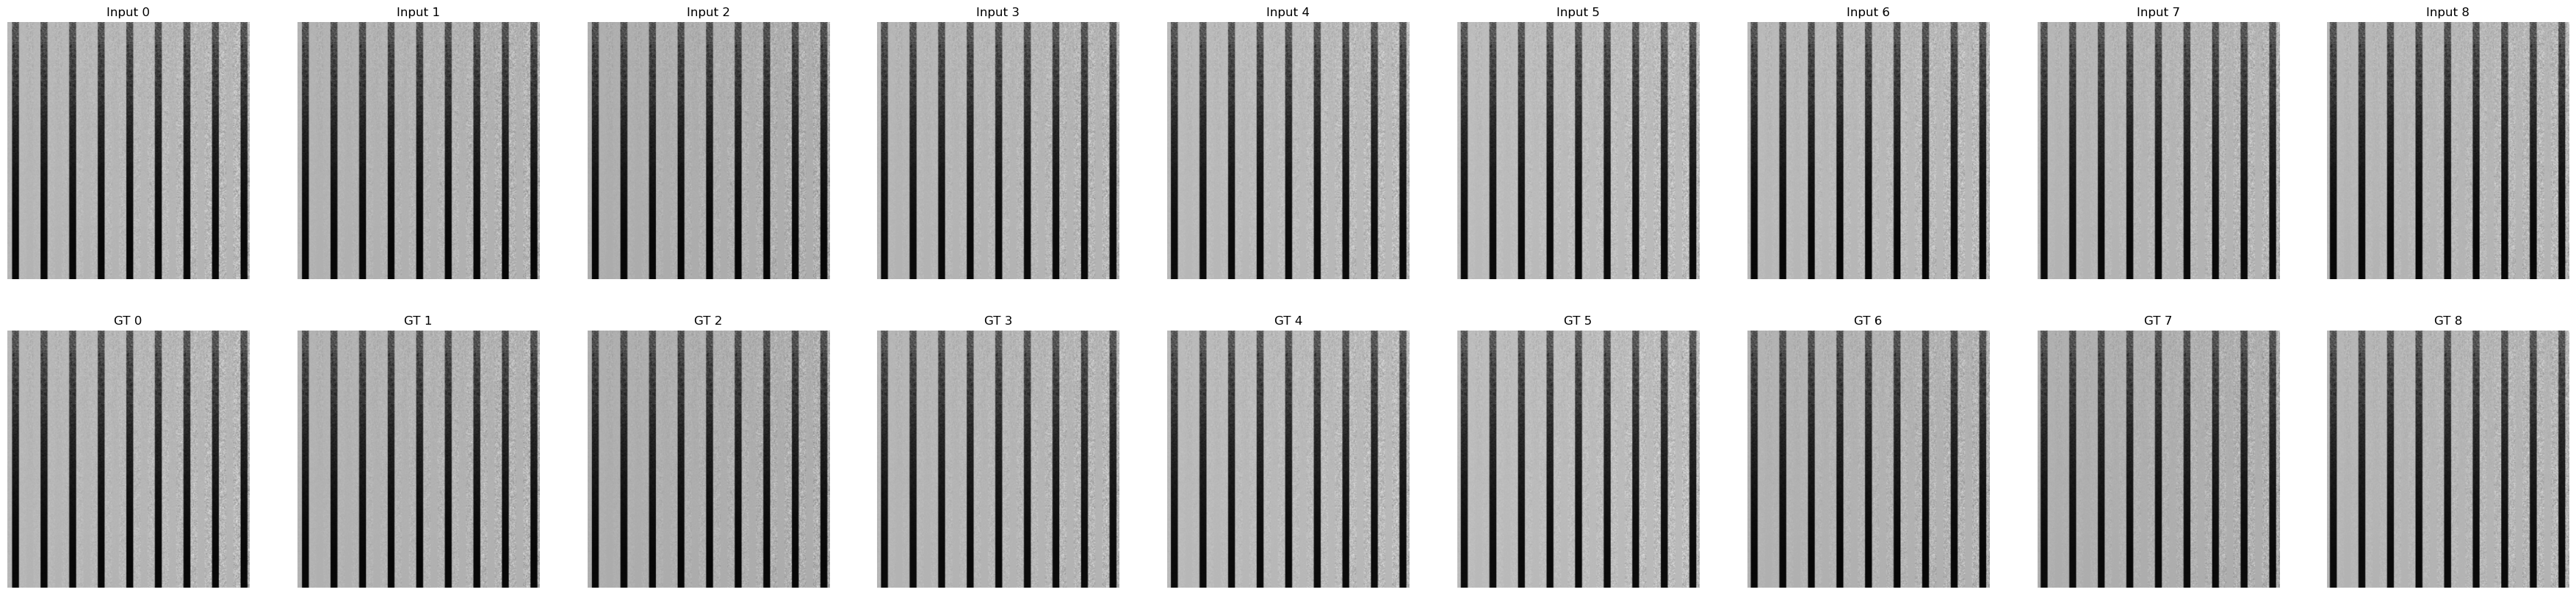

In [23]:
base_path = r"F:\lab\EPINET_MobileViT\dataset\hci_dataset"  # ここに画像ファイルのあるディレクトリを指定してください
dataset = CustomDataset(base_path, val_dataset_list, flag_print_distorted_path=True,flag_GT_output=True)
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

data_iter = iter(test_dataloader)
images = next(data_iter)

# input_multiviewフォルダの設定と作成
input_folder = "./input_multiview"
os.makedirs(input_folder, exist_ok=True)

# GT_multiviewフォルダの設定と作成
gt_folder = "./GT_multiview"
os.makedirs(gt_folder, exist_ok=True)

# 各画像を個別に保存
for i in range(9):
    fig, ax = plt.subplots(figsize=(5, 5))  # それぞれの画像に対して個別のプロットを作成
    img = images[0][0][i].numpy()  # テンソルをnumpy配列に変換
    ax.imshow(img, cmap='gray', aspect='auto')
    ax.axis('off')  # 軸を非表示にする
    
    # ファイル名を指定して画像を保存
    output_file = os.path.join(input_folder, f"multiview_input_{i}.png")
    fig.savefig(output_file, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

print(f"Input images saved to {input_folder}")

# 各GT画像を個別に保存
for i in range(9):
    fig, ax = plt.subplots(figsize=(5, 5))  # それぞれの画像に対して個別のプロットを作成
    img = images[1][0][i].numpy()  # テンソルをnumpy配列に変換
    ax.imshow(img, cmap='gray', aspect='auto')
    ax.axis('off')  # 軸を非表示にする
    
    # ファイル名を指定して画像を保存
    output_file = os.path.join(gt_folder, f"multiview_gt_{i}.png")
    fig.savefig(output_file, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

print(f"GT images saved to {gt_folder}")

# 保存した画像をサブプロットとして表示
fig, axes = plt.subplots(2, 9, figsize=(45, 10))  # 2行に設定

# 入力画像のサブプロット
for i in range(9):
    img_path = os.path.join(input_folder, f"multiview_input_{i}.png")
    img = plt.imread(img_path)
    axes[0, i].imshow(img, cmap='gray', aspect='auto')
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Input {i}")

# GT画像のサブプロット
for i in range(9):
    img_path = os.path.join(gt_folder, f"multiview_gt_{i}.png")
    img = plt.imread(img_path)
    axes[1, i].imshow(img, cmap='gray', aspect='auto')
    axes[1, i].axis('off')
    axes[1, i].set_title(f"GT {i}")

plt.show()

#### 出力（揺れの抑えられた多視点画像)

Output shape: torch.Size([1, 9, 512, 512])
Images saved to ./output_multiview


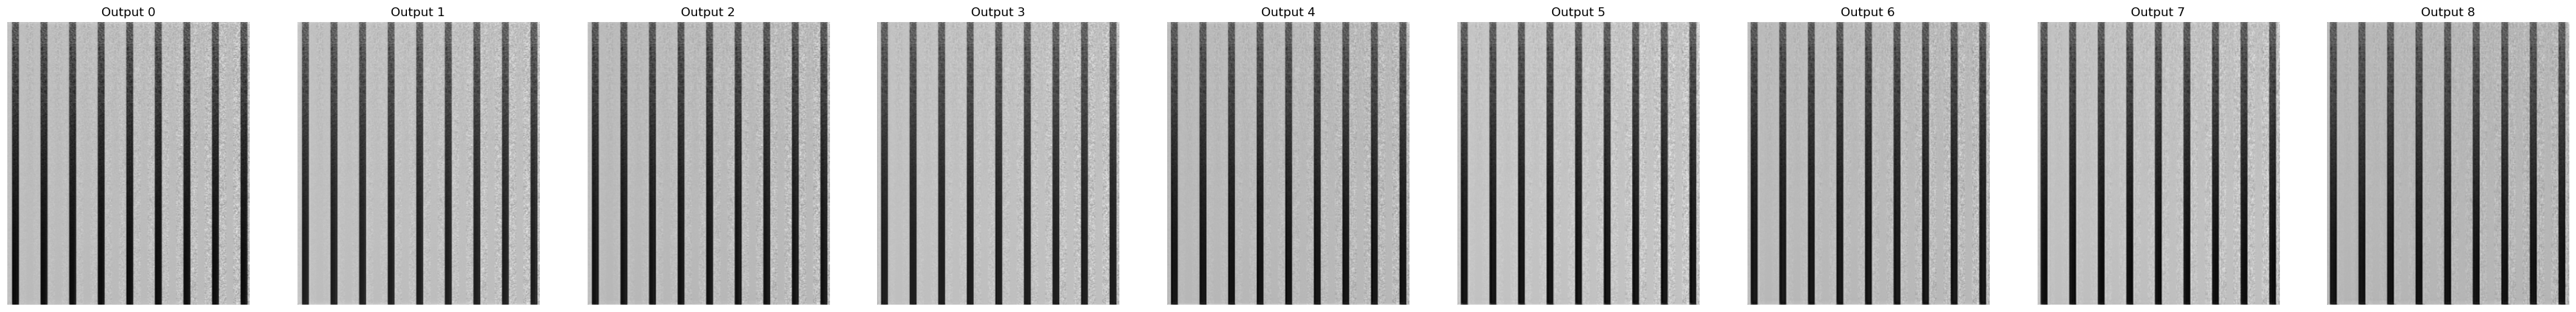

In [24]:
output_folder = "./output_multiview"
os.makedirs(output_folder, exist_ok=True)

# 推論を実行し、出力テンソルを取得
with torch.no_grad():
    input_tensor = images[0].cuda()
    output = UNet(input_tensor).cpu()
    
output_shape = output.shape
print(f"Output shape: {output_shape}")

# 出力テンソルの各チャネルを画像として保存
for i in range(9):
    img = output[0][i].numpy()  # テンソルをnumpy配列に変換
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img, cmap='gray', aspect='auto')
    ax.axis('off')  # 軸を非表示にする
    img_path = os.path.join(output_folder, f"output_image_{i}.png")
    fig.savefig(img_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

print(f"Images saved to {output_folder}")

# 保存した画像をサブプロットとして表示
fig, axes = plt.subplots(1, 9, figsize=(45, 5))
for i in range(9):
    img_path = os.path.join(output_folder, f"output_image_{i}.png")
    img = plt.imread(img_path)
    axes[i].imshow(img, cmap='gray', aspect='auto')
    axes[i].axis('off')  # 軸を非表示にする
    axes[i].set_title(f"Output {i}")

plt.show()

#### Plot EPI

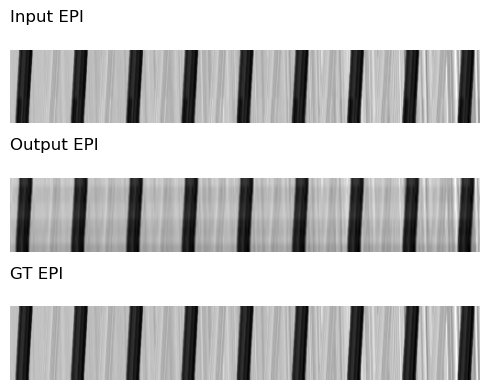

In [25]:
input_EPI = B9HW_to_BH9W_EPI_gen(images[0], 1)
GT_EPI = B9HW_to_BH9W_EPI_gen(images[1][0].unsqueeze(0),1)
output_EPI = B9HW_to_BH9W_EPI_gen(output, 1)

img1 = input_EPI[0,10, :, :].numpy()
img2 = output_EPI[0,10, :, :].numpy()
img3 = GT_EPI[0,10,:,:].numpy()

# 2つの画像を上下に並べてサブプロット
fig, axes = plt.subplots(3, 1, figsize=(5, 4))  # figsizeを調整して見やすくする

# 最初の画像をプロット
axes[0].imshow(img1, cmap='gray', aspect='auto')
axes[0].set_title('Input EPI', loc='left', pad=20)  # タイトルを左に配置
axes[0].axis('off')  # 軸を非表示にする

# 2番目の画像をプロット
axes[1].imshow(img2, cmap='gray', aspect='auto')
axes[1].set_title('Output EPI', loc='left', pad=20)  # タイトルを左に配置
axes[1].axis('off')  # 軸を非表示にする

# 3番目の画像をプロット
axes[2].imshow(img3, cmap='gray', aspect='auto')
axes[2].set_title('GT EPI', loc='left', pad=20)  # タイトルを左に配置
axes[2].axis('off')  # 軸を非表示にする

plt.tight_layout()  # プロットが重ならないようにレイアウトを調整
plt.show()

In [26]:
def save_validation_tensor_as_png(tensor,save_path):

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    tensor = tensor.detach().cpu().numpy()
    normalized_image = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    image_uint8 = np.uint8(normalized_image * 255)

    concatenated_images = np.hstack(image_uint8)
    imageio.imsave(save_path, np.squeeze(concatenated_images))

def save_tensor_as_png(tensor,save_path):

    tensor = tensor.detach().cpu().numpy()
    imageio.imsave(save_path, np.squeeze(tensor))

In [27]:
def display_current_output(train_output, traindata_label, save_path):
    '''
        display current results from EPINET
        and save results in /current_output
    '''

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    sz=len(traindata_label)
    train_output=np.squeeze(train_output)
    if(len(traindata_label.shape)>3 and traindata_label.shape[-1]==9): # traindata
        pad1_half=int(0.5*(np.size(traindata_label,1)-np.size(train_output,1)))
        train_label482=traindata_label[:,15:-15,15:-15,4,4]
    else: # valdata
        pad1_half=int(0.5*(np.size(traindata_label,1)-np.size(train_output,1)))
        train_label482=traindata_label[:,15:-15,15:-15]

    train_output482=train_output[:,15-pad1_half:482+15-pad1_half,15-pad1_half:482+15-pad1_half]

    train_diff=np.abs(train_output482-train_label482)
    train_bp=(train_diff>=0.07)
    condition = train_bp > 0

    bp_img=np.zeros_like(train_bp)
    bp_img[condition] = 1
    bp_img[~condition] = 0
    

    train_output482_all=np.zeros((3*482,sz*482),np.uint8)
    train_output482_all[0:482,:]=np.uint8(25*np.reshape(np.transpose(train_label482,(1,0,2)),(482,sz*482))+100)
    train_output482_all[482:2*482,:]=np.uint8(25*np.reshape(np.transpose(train_output482,(1,0,2)),(482,sz*482))+100)
    train_output482_all[2*482:3*482,:]=np.uint8(25*np.reshape(np.transpose(bp_img,(1,0,2)),(482,sz*482))+100)

    imageio.imsave(save_path, np.squeeze(train_output482_all))

    return train_diff, train_bp

In [28]:
def statistical_check(input_tensor):

    image_data = input_tensor.numpy()
    min_val, max_val = image_data.min(), image_data.max()
    print(f"Image data min: {min_val}, max: {max_val}")

    image_data = (image_data - min_val) / (max_val - min_val) * 255
    image_data = image_data.astype(np.uint8)

    plt.figure(figsize=(10, 6))
    plt.hist(image_data.ravel(), bins=256, range=(0, 255), color='blue', alpha=0.7)
    plt.title(f"Pixel Value Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # 画像を表示
    plt.imshow(image_data[0,0,:,:], cmap='viridis')
    plt.axis('off')  # 座標軸を非表示にする
    plt.show()

In [29]:
def make_multiinput_realworld_1stream(input_dir):
    
    image_files = sorted([f for f in os.listdir(input_dir) if f.endswith('.png')])
    
    first_image_path = os.path.join(input_dir, image_files[0])
    with Image.open(first_image_path) as img:
        width, height = img.size
    
    num_images = len(image_files)
    grayscale_array = np.zeros((num_images, height, width), dtype=np.uint8)
    
    RGB_weights = [0.299, 0.587, 0.114]
    
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(input_dir, image_file)
        with Image.open(image_path) as img:
            img_array = np.array(img)
            grayscale_array[i] = np.dot(img_array[...,:3], RGB_weights).astype(np.uint8)
    
    return grayscale_array

In [30]:
input_size=23+2         # Input size should be greater than or equal to 23
label_size=input_size-22 # Since label_size should be greater than or equal to 1
Setting02_AngualrViews = np.array([0,1,2,3,4,5,6,7,8])  # number of views ( 0~8 for 9x9 )

EPINETD = EPINET_D(input_ch = input_ch, filter_num = filter_num, stream_num =stream_num).to("cuda")
checkpoint = torch.load(r"F:\lab\EPINET_MobileViT\EPINET_Torch\1Stream_DWSC_v1\model_checkpoint\epoch_194882_training_Loss_updated_loss_0p024426649082452057.pth")
EPINETD.load_state_dict(checkpoint['model_state'])
EPINETD.eval()



EPINET_D(
  (multistream1): multi_stream_DWSC(
    (conv): Sequential(
      (0): DWSCBlock(
        (depthwise_conv1): Conv2d(9, 9, kernel_size=(2, 2), stride=(1, 1), groups=9, bias=False)
        (pointwise_conv1): Conv2d(9, 70, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu1): ReLU()
        (depthwise_conv2): Conv2d(70, 70, kernel_size=(2, 2), stride=(1, 1), groups=70, bias=False)
        (pointwise_conv2): Conv2d(70, 70, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU()
      )
    )
  )
  (multistream2): multi_stream_DWSC(
    (conv): Sequential(
      (0): DWSCBlock(
        (depthwise_conv1): Conv2d(70, 70, kernel_size=(2, 2), stride=(1, 1), groups=70, bias=False)
        (pointwise_conv1): Conv2d(70, 70, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu1): ReLU()
        (depthwise_conv2): Conv2d(70, 70, kernel_size=(2, 2), stride=

### 歪みありを入力した場合

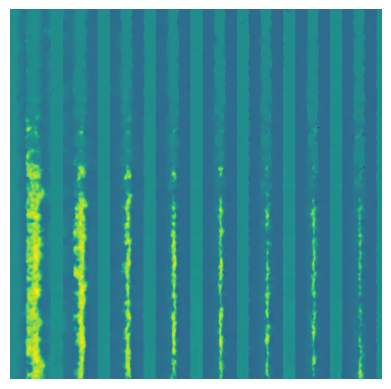

In [31]:
val_0d = make_multiinput_realworld_1stream(r"F:\lab\EPINET_MobileViT\EPI_Stabilization\UNet_EPI_Stabilization\input_multiview")

img_scale_sampling_rate = 1
tensor = torch.tensor(val_0d[:,::img_scale_sampling_rate,::img_scale_sampling_rate], dtype=torch.float32).unsqueeze(0)
tensor.shape

batch = 0

x_0d = tensor.float().clone().to("cuda") / 255.0
x = EPINETD(x_0d)

x = x.cpu().detach().numpy()
image_data = x[0, 0, :, :]
input_data = x_0d[0, 0, :, :].cpu().detach().numpy()

plt.imshow(image_data)
plt.axis('off')  # 座標軸を非表示にする
plt.show()

#### 歪みなしを入力した場合

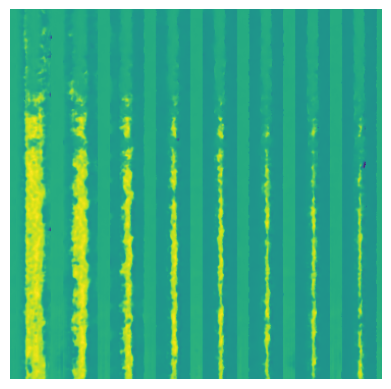

In [32]:
val_0d = make_multiinput_realworld_1stream(r"F:\lab\EPINET_MobileViT\EPI_Stabilization\UNet_EPI_Stabilization\GT_multiview")

img_scale_sampling_rate = 1
tensor = torch.tensor(val_0d[:,::img_scale_sampling_rate,::img_scale_sampling_rate], dtype=torch.float32).unsqueeze(0)
tensor.shape

batch = 0

x_0d = tensor.float().clone().to("cuda") / 255.0
x = EPINETD(x_0d)

x = x.cpu().detach().numpy()
image_data = x[0, 0, :, :]
input_data = x_0d[0, 0, :, :].cpu().detach().numpy()

plt.imshow(image_data)
plt.axis('off')  # 座標軸を非表示にする
plt.show()

#### 歪みを補正したものを入力した場合

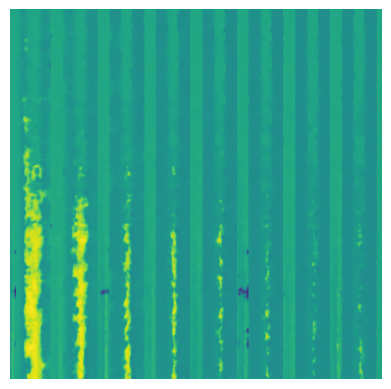

In [33]:
val_0d = make_multiinput_realworld_1stream(r"F:\lab\EPINET_MobileViT\EPI_Stabilization\UNet_EPI_Stabilization\output_multiview")

img_scale_sampling_rate = 1
tensor = torch.tensor(val_0d[:,::img_scale_sampling_rate,::img_scale_sampling_rate], dtype=torch.float32).unsqueeze(0)
tensor.shape

batch = 0

x_0d = tensor.float().clone().to("cuda") / 255.0
x = EPINETD(x_0d)

x = x.cpu().detach().numpy()
image_data = x[0, 0, :, :]
input_data = x_0d[0, 0, :, :].cpu().detach().numpy()

plt.imshow(image_data)
plt.axis('off')  # 座標軸を非表示にする
plt.show()